
# Modelo Utilizado e Justificativas

Neste projeto, optou-se por usar um modelo LSTM (Long Short-Term Memory), que é um tipo de rede neural recorrente (RNN). As LSTMs são especialmente eficazes para modelagem de séries temporais, como os preços de criptomoedas, por terem a capacidade de capturar dependências de longo prazo nos dados. Isso é importante, pois os preços de mercado tendem a ser influenciados por valores históricos, e o LSTM pode lembrar de padrões que ocorreram no passado e que afetam os valores futuros.

As LSTMs se destacam em prever valores futuros com base em sequências anteriores, uma vez que seus "células de memória" permitem que a rede mantenha informações relevantes durante a análise de longas sequências de dados. No caso do preço do Bitcoin, os valores anteriores são uma forte indicação de possíveis movimentos futuros, o que torna esse modelo particularmente adequado para prever o preço de fechamento.


In [10]:
!pip install yfinance
!pip install pandas numpy matplotlib scikit-learn tensorflow


In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime, timedelta


In [12]:
today = datetime.today()
df = yf.download('BTC-USD', start='2015-01-01', end=today)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]  # Use selected columns
df.head(100)


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,55629100
2015-01-05,265.084015,278.341003,265.084015,274.473999,43962800
...,...,...,...,...,...
2015-04-06,260.721008,261.798004,254.574997,255.492004,20034200
2015-04-07,255.274002,255.804993,252.205002,253.179993,18467400
2015-04-08,253.063995,253.847000,244.214996,245.022003,30086400


In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60

X, y = create_sequences(scaled_data, seq_length)

X = X.reshape((X.shape[0], X.shape[1], 1))


In [14]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# Bloco de Atenção

A inclusão de um bloco de atenção foi adicionada para melhorar o desempenho do modelo. Embora o LSTM capture dependências temporais, nem todas as informações na sequência têm o mesmo peso para a previsão. O bloco de atenção foi introduzido para permitir que o modelo dê mais importância a certos pontos na sequência que são mais relevantes para a previsão.

O mecanismo de atenção calcula "pesos de atenção" que indicam a importância de cada passo no tempo dentro da sequência. Esses pesos são aplicados às saídas da camada LSTM, ajustando os dados que o modelo utiliza para tomar sua decisão final. O bloco de atenção, portanto, ajuda o modelo a se concentrar nas partes mais significativas da sequência, melhorando a precisão da previsão ao destacar as informações mais úteis.



In [15]:
def attention_block(inputs):
    attention_weights = layers.Dense(1, activation='tanh')(inputs)
    attention_weights = layers.Flatten()(attention_weights)
    attention_weights = layers.Activation('softmax')(attention_weights)
    attention_weights = layers.RepeatVector(128)(attention_weights)
    attention_weights = layers.Permute([2, 1])(attention_weights)

    weighted_inputs = layers.Multiply()([inputs, attention_weights])
    return weighted_inputs

input_shape = (X_train.shape[1], 1)

inputs = layers.Input(shape=input_shape)

lstm_out = layers.LSTM(128, return_sequences=True)(inputs)

attention_out = attention_block(lstm_out)

combined_out = layers.Flatten()(attention_out)
dense_out = layers.Dense(64, activation='relu')(combined_out)

output = layers.Dense(1, activation='linear')(dense_out)

model = models.Model(inputs=inputs, outputs=output)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 60, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 60, 128)        │         66,560 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 60, 1)          │            129 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 60)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 60)             │              0 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 128, 60)        │              0 │ activation[0][0]       │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute (Permute)         │ (None, 60, 128)        │              0 │ repeat_vector[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 60, 128)        │              0 │ lstm_2[0][0],          │
│                           │                        │                │ permute[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 7680)           │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │        491,584 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │             65 │ dense_3[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 558,338 (2.13 MB)

 Trainable params: 558,338 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 25s 203ms/step - loss: 0.0249 - mae: 0.0926 - val_loss: 0.0129 - val_mae: 0.0865
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 0.0031 - mae: 0.0303 - val_loss: 0.0034 - val_mae: 0.0425
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 0.0019 - mae: 0.0240 - val_loss: 0.0063 - val_mae: 0.0550
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - loss: 0.0017 - mae: 0.0224 - val_loss: 0.0032 - val_mae: 0.0391
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - loss: 0.0012 - mae: 0.0189 - val_loss: 0.0026 - val_mae: 0.0368


# Estrutura do Modelo

O modelo híbrido criado é composto por uma camada LSTM, seguida pelo bloco de atenção para refinar a saída, e, finalmente, camadas densas para fazer a previsão do preço de fechamento.

Camada LSTM: A camada LSTM captura as dependências temporais do histórico de preços. Utilizamos 128 unidades LSTM, permitindo ao modelo reter informações suficientes sobre a sequência de entrada de 60 dias.

Bloco de Atenção: Aplica pesos de atenção às saídas do LSTM, permitindo que o modelo identifique os pontos mais relevantes dentro da sequência.

Camada Densa: Após o bloco de atenção, usamos uma camada densa com 64 neurônios para processar as informações e, por fim, uma camada de saída com um único neurônio, que gera a previsão do preço de fechamento.

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0013 - mae: 0.0266
Test MAE: 0.03678290918469429


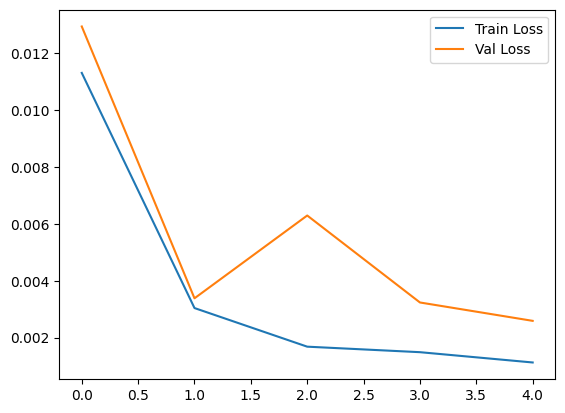

In [18]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {test_mae}')

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()


# Treinamento e Avaliação

O modelo é compilado com o otimizador Adam, que é eficaz para modelos como LSTMs, e a função de perda escolhida é o erro quadrático médio (MSE), que é adequada para problemas de regressão, como a previsão de preços. O treinamento é interrompido precocemente utilizando a técnica de Early Stopping, que monitora a perda na validação e evita o overfitting, restaurando os melhores pesos quando a validação não melhora após algumas épocas.




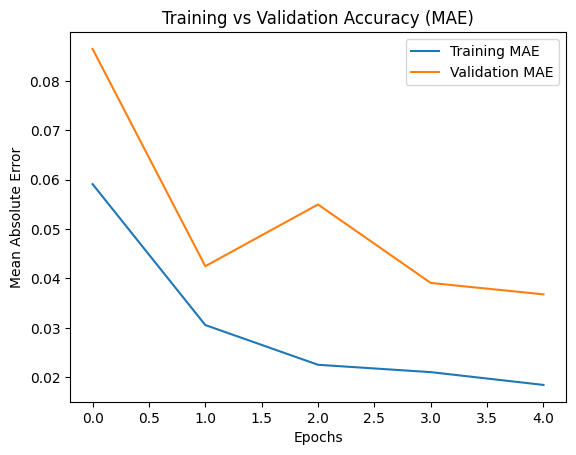

In [19]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training vs Validation Accuracy (MAE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()


# Previsões Futuras

Além de avaliar o desempenho nos dados de teste, foi implementada uma função para fazer previsões futuras de preços. Esta função utiliza a sequência final dos dados históricos para prever os próximos preços de fechamento para diferentes períodos, como um dia, uma semana, um mês e até um ano, permitindo assim uma análise mais ampla das tendências do mercado de criptomoedas.



22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


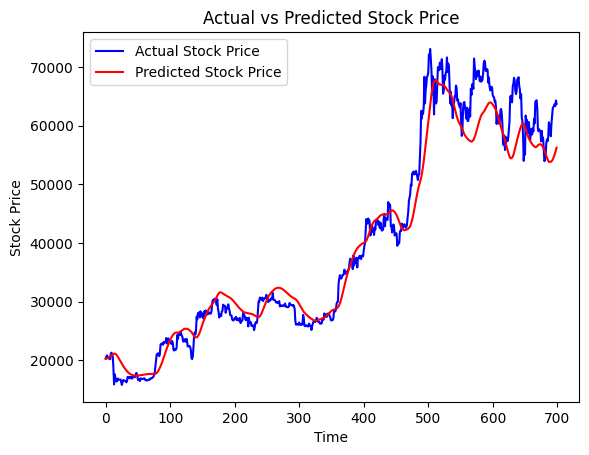

In [20]:
predicted_stock_price = model.predict(X_test)

predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.plot(y_test_actual, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Actual vs Predicted Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [21]:
import numpy as np

def predict_future_prices(model, data, scaler, sequence_length, steps):
    """
    Predict future prices for a given number of steps (days).

    model: Trained LSTM model.
    data: Last available sequence data for predictions (scaled).
    scaler: Scaler object to reverse the scaling.
    sequence_length: The length of the sequence used by the model (e.g., 60 days).
    steps: Number of future steps to predict (e.g., 1 for day, 7 for week, etc.).

    Returns:
    predictions: Array of predicted future prices (unscaled).
    """
    current_sequence = data[-sequence_length:]

    future_predictions = []

    for _ in range(steps):
        current_sequence_reshaped = current_sequence.reshape((1, sequence_length, 1))

        predicted_price_scaled = model.predict(current_sequence_reshaped)

        predicted_price = scaler.inverse_transform(predicted_price_scaled)[0][0]
        future_predictions.append(predicted_price)

        predicted_price_scaled = np.array(predicted_price_scaled).reshape((1, 1))
        current_sequence = np.append(current_sequence, predicted_price_scaled)[-sequence_length:]

    return future_predictions



In [22]:

last_sequence = scaled_data[-seq_length:]

next_day_prediction = predict_future_prices(model, last_sequence, scaler, seq_length, steps=1)
print(f'Next Day Prediction: {next_day_prediction}')

next_week_predictions = predict_future_prices(model, last_sequence, scaler, seq_length, steps=7)
print(f'Next Week Predictions: {next_week_predictions}')

next_month_predictions = predict_future_prices(model, last_sequence, scaler, seq_length, steps=30)
print(f'Next Month Predictions: {next_month_predictions}')



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Next Day Prediction: [56657.535]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Next Week Predictions: [56657.535, 56954.742, 57137.727, 57226.59, 57226.082, 57164.53, 57021.97]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/